In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import gcsfs
import fsspec
import xesmf as xe
import warnings
import fiona
import rasterio
import regionmask
warnings.filterwarnings('ignore')

import geopandas as gpd


# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
col_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

In [3]:
PATH_TO_SHAPEFILE = 'basins_with_hydrologic_ranges_quartiles.dbf'
basins_to_test = gpd.read_file(PATH_TO_SHAPEFILE)
# Remove the basins that don't have geometries attached to them
basins_to_test = basins_to_test[basins_to_test.geometry!=None]

In [6]:
era_basins = gpd.read_file('basins_era_range.dbf')
era_basins = era_basins[era_basins.geometry!=None]

In [7]:
def compare_mean_std_biases(gcm_basins, era_basins):
    means_gcms = gcm_basins.iloc[0:]['mean'].values
    stds_gcms = gcm_basins.iloc[0:]['hydrologic'].values
    mean_errors = np.array([means_gcms - gcm_basins.iloc[0:]['lower_quar'],
                   gcm_basins.iloc[0:]['upper_quar'] - means_gcms])
    std_errors = np.array([stds_gcms - gcm_basins.iloc[0:]['lower_qu_2'],
                   gcm_basins.iloc[0:]['upper_qu_2'] - stds_gcms])
    means_era = era_basins.iloc[0:]['mean'].values
    std_era = era_basins.iloc[0:]['hydrologic'].values
    mean_biases = ((means_gcms - means_era)/means_era)*100
    mean_bias_errors = (mean_errors/np.expand_dims(means_era, 0))*100
    std_biases = stds_gcms - std_era
    return mean_biases, std_biases, mean_bias_errors, std_errors

In [8]:
era5_precip = xr.open_dataset('era5_monthly_tp_cesm2grid.nc')
era5_runoff = xr.open_dataset('era5_monthly_runoff_cesm2grid.nc')
era5_temp = xr.open_dataset('era5_mean_t2m_cesm2grid.nc')

In [9]:
mask = xr.open_dataset('basin_masks.nc')

In [17]:
def calc_basin_variable(in_variables, metric, masks, basins_gdf_in):
    '''Input: 
    in_variables: a list of datasets; could be just one (for mean_temp)
    or two (precip and runoff for runoff_ratio) datasets with variables 
    metric: 'runoff_ratio' or 'mean_temp'
    '''
    if metric == 'runoff_ratio':
        precip_da = in_variables[0]
        runoff_da = in_variables[1]
        precip_da = precip_da.rename({'lon': 'longitude',
                           'lat': 'latitude'})
        precip_da = precip_da.assign_coords(longitude=(((precip_da.longitude + 180) % 360) 
                                             - 180)).sortby('longitude')

        runoff_da = runoff_da.rename({'lon': 'longitude',
                           'lat': 'latitude'})
        runoff_da = runoff_da.assign_coords(longitude=(((runoff_da.longitude + 180) % 360) 
                                             - 180)).sortby('longitude')
    elif metric == 'mean_temp':
        temp_da = in_variables[0]
        temp_da = temp_da.rename({'lon': 'longitude',
                           'lat': 'latitude'})
        temp_da = temp_da.assign_coords(longitude=(((temp_da.longitude + 180) % 360) 
                                             - 180)).sortby('longitude')

    basins_gdf_out = basins_gdf_in.copy(deep=True)
    basins_gdf_out[metric] = np.nan
    lat = masks.latitude.values
    lon = masks.longitude.values
    for ID_REGION in range(0,254):
        print(ID_REGION)
        sel_mask = masks.where(masks == ID_REGION).values
        if (~np.isnan(sel_mask)).sum() < 10:
            print('{} is too small!'.format(ID_REGION))
            continue
        id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
        id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
        if metric=='runoff_ratio':
            basin_average_precip = precip_da.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                            longitude = slice(id_lon[0], id_lon[-1])
                           ).compute().where(masks == ID_REGION).mean(dim=['latitude', 'longitude'])
            basin_average_runoff = runoff_da.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                            longitude = slice(id_lon[0], id_lon[-1])
                           ).compute().where(masks == ID_REGION).mean(dim=['latitude', 'longitude'])
        elif metric=='mean_temp':
            basin_average_temp = temp_da.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                            longitude = slice(id_lon[0], id_lon[-1])
                           ).compute().where(masks == ID_REGION).mean(dim=['latitude', 'longitude'])
        # also add total runoff as a freebie
        if metric == 'runoff_ratio':
            basins_gdf_out.at[ID_REGION, metric] = basin_average_runoff.ro.values/basin_average_precip.tp.values
        elif metric == 'mean_temp':
            basins_gdf_out.at[ID_REGION, metric] = basin_average_temp.t2m.values
        
    return basins_gdf_out

In [13]:
new_basins = calc_basin_variable([era5_precip.mean(dim='time'), era5_runoff.mean(dim='time')], 
                                     'runoff_ratio',
                                     mask.region, era_basins)

0
1
2
3
3 is too small!
4
5
6
6 is too small!
7
7 is too small!
8
8 is too small!
9
9 is too small!
10
11
12
12 is too small!
13
13 is too small!
14
14 is too small!
15
16
16 is too small!
17
17 is too small!
18
19
19 is too small!
20
21
22
23
24
25
26
26 is too small!
27
27 is too small!
28
29
30
31
32
32 is too small!
33
33 is too small!
34
34 is too small!
35
36
37
38
38 is too small!
39
39 is too small!
40
40 is too small!
41
42
43
43 is too small!
44
44 is too small!
45
46
47
48
49
49 is too small!
50
51
51 is too small!
52
53
54
54 is too small!
55
55 is too small!
56
56 is too small!
57
57 is too small!
58
59
59 is too small!
60
60 is too small!
61
61 is too small!
62
62 is too small!
63
63 is too small!
64
64 is too small!
65
65 is too small!
66
67
67 is too small!
68
69
69 is too small!
70
71
72
72 is too small!
73
73 is too small!
74
74 is too small!
75
75 is too small!
76
76 is too small!
77
77 is too small!
78
78 is too small!
79
79 is too small!
80
80 is too small!
81
81 i

In [18]:
new_basins = calc_basin_variable([era5_temp], 'mean_temp', mask.region, new_basins)

0
1
2
3
3 is too small!
4
5
6
6 is too small!
7
7 is too small!
8
8 is too small!
9
9 is too small!
10
11
12
12 is too small!
13
13 is too small!
14
14 is too small!
15
16
16 is too small!
17
17 is too small!
18
19
19 is too small!
20
21
22
23
24
25
26
26 is too small!
27
27 is too small!
28
29
30
31
32
32 is too small!
33
33 is too small!
34
34 is too small!
35
36
37
38
38 is too small!
39
39 is too small!
40
40 is too small!
41
42
43
43 is too small!
44
44 is too small!
45
46
47
48
49
49 is too small!
50
51
51 is too small!
52
53
54
54 is too small!
55
55 is too small!
56
56 is too small!
57
57 is too small!
58
59
59 is too small!
60
60 is too small!
61
61 is too small!
62
62 is too small!
63
63 is too small!
64
64 is too small!
65
65 is too small!
66
67
67 is too small!
68
69
69 is too small!
70
71
72
72 is too small!
73
73 is too small!
74
74 is too small!
75
75 is too small!
76
76 is too small!
77
77 is too small!
78
78 is too small!
79
79 is too small!
80
80 is too small!
81
81 i

In [42]:
mean_biases, std_biases, \
mean_bias_errors, std_errors = compare_mean_std_biases(basins_to_test[new_basins['Sufficient'] > 9], 
                                                       new_basins[new_basins['Sufficient'] > 9])

In [69]:
def scatter_errorbar_plot(x_placement, y_placement, error_bars, 
                          labels, colors, sizes, x_limits, y_limits,
                         x_label, y_label, c_label, fig_path):
    # first plot all basins
    plt.figure(figsize=(16,8))
    plt.errorbar(x_placement, 
                 y_placement, 
                 yerr=error_bars, fmt= 'k.', markersize=0, elinewidth=0.5, capsize=0, alpha=0.5)
    scatterplot = plt.scatter(x_placement, 
                 y_placement, 
                s=sizes,
               c=colors)
    for i in range(len(y_placement)):
        if y_placement[i] <y_limits[1]:
            plt.text(x_placement[i], 
                     y_placement[i], 
                     labels[i])
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.axhline(0, color='k')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.colorbar(scatterplot, label=c_label)

    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    from matplotlib.patches import Circle

    legend_elements = [Line2D([0], [0], color='k', lw=1, label='Intraquartile range', alpha=0.5,), 
                      Line2D(range(1), range(1), color='w', marker='o', markerfacecolor="darkcyan", 
                             label='River basin (size indicates annual runoff)', markersize=12),]

    # Create the figure
    plt.legend(handles=legend_elements, loc='upper left')
    plt.savefig(fig_path, format='svg')

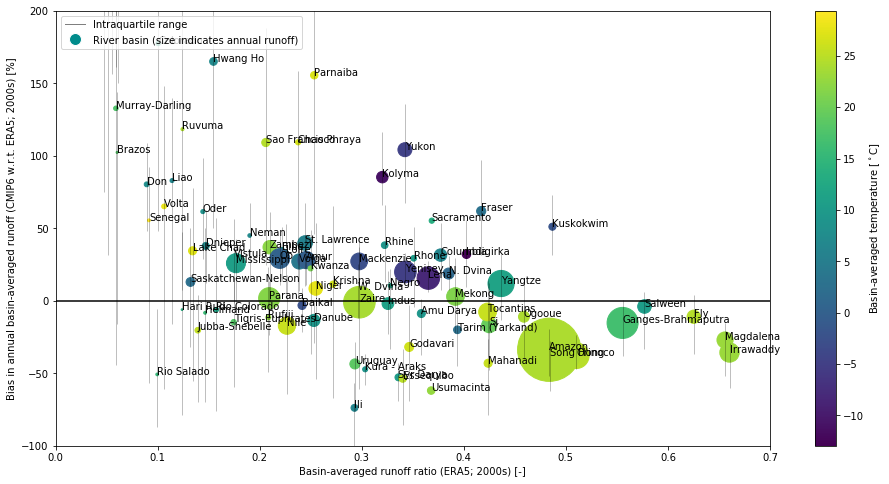

In [70]:
scatter_errorbar_plot(new_basins[new_basins['Sufficient'] > 9]['runoff_ratio'].values,
                     mean_biases,mean_bias_errors,
                      new_basins[new_basins['Sufficient'] > 9]['NAME'].values,
                      new_basins['mean_temp'][new_basins['Sufficient'] >9].values-273.15,
                     (new_basins['mean']*new_basins['Sufficient'])[new_basins['Sufficient'] > 9 ].values*100,
                      [0,0.7],
                      [-100,200],
                      'Basin-averaged runoff ratio (ERA5; 2000s) [-]',
                       'Bias in annual basin-averaged runoff (CMIP6 w.r.t. ERA5; 2000s) [%]' ,
                      'Basin-averaged temperature [$^\circ$C]',
                      '../figures/basin_scatter_plot_mean_smaller.svg')

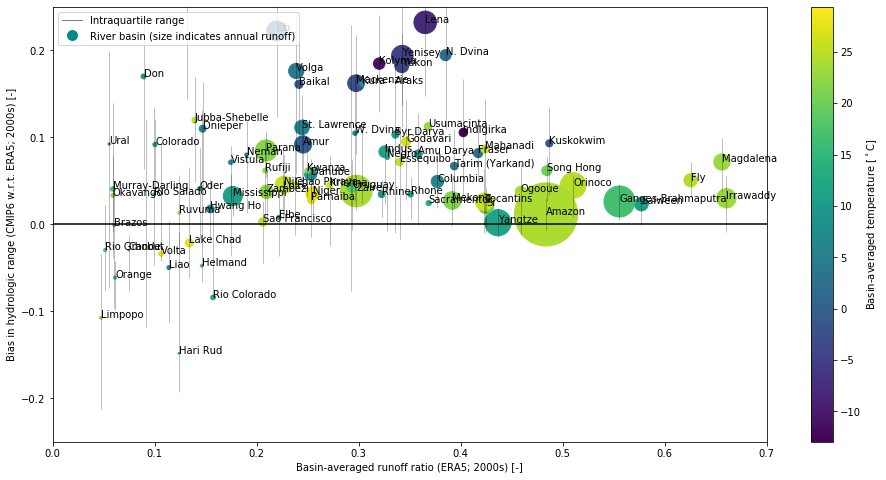

In [71]:
scatter_errorbar_plot(new_basins[new_basins['Sufficient'] > 9]['runoff_ratio'].values,
                     std_biases,
                      std_errors,
                      new_basins[new_basins['Sufficient'] > 9]['NAME'].values,
                      new_basins['mean_temp'][new_basins['Sufficient'] >9].values-273.15,
                     (new_basins['mean']*new_basins['Sufficient'])[new_basins['Sufficient'] > 9 ].values*100,
                      [0,0.7],
                      [-0.25,0.25],
                      'Basin-averaged runoff ratio (ERA5; 2000s) [-]',
                      'Bias in hydrologic range (CMIP6 w.r.t. ERA5; 2000s) [-]',
                      'Basin-averaged temperature [$^\circ$C]',
                      '../figures/basin_scatter_plot_mean_smaller.svg')

# now make the same plots but for gcm changes 

In [ ]:
# first load in a single gcm projection

In [95]:
PATH_TO_SHAPEFILE = 'IPSL.IPSL-CM6A-LR_ssp585_polygon_changes_fullbasins.dbf'
gcm_basins = gpd.read_file(PATH_TO_SHAPEFILE)
# Remove the basins that don't have geometries attached to them
gcm_basins = gcm_basins[gcm_basins.geometry!=None]
# Remove the basins that have nans for their means or h_ranges
gcm_basins = gcm_basins[~np.isnan(gcm_basins['mean'].values)]

In [ ]:
# then loop and add them all together

In [107]:
sample_gpd[['NAME', 'mean']].set_index('NAME')

,mean
NAME,
Yenisey,0.232507
Tana,0.158392
Yukon,0.130853
Kemijoki,0.166636
Tornio,-0.020554
...,...
Mano-Morro,1.558394
Essequibo,0.327396
Omo Wenz,0.653684


In [125]:
# gpd_dict = {}
# means, h_ranges = [], []

# for gcm in ['CAMS.CAMS-CSM1-0', 'BCC.BCC-CSM2-MR',
#              'CSIRO-ARCCSS.ACCESS-CM2', 'EC-Earth-Consortium.EC-Earth3-Veg',
#              'INM.INM-CM4-8', 'INM.INM-CM5-0', 'MIROC.MIROC-ES2L',
#             'MRI.MRI-ESM2-0', 'NIMS-KMA.KACE-1-0-G',
#              'UA.MCM-UA-1-0', 'NOAA-GFDL.GFDL-CM4',
#             'NCAR.CESM2', 'CSIRO.ACCESS-ESM1-5',
#              'MPI-M.MPI-ESM1-2-LR', 'MIROC.MIROC6',
#              'FIO-QLNM.FIO-ESM-2-0', 'CCCma.CanESM5-CanOE',
#              'CNRM-CERFACS.CNRM-ESM2-1', 'CNRM-CERFACS.CNRM-CM6-1',
#                     'MOHC.UKESM1-0-LL', 'NCAR.CESM2-WACCM', 'IPSL.IPSL-CM6A-LR']:
#     PATH_TO_SHAPEFILE = '{}_ssp585_polygon_changes_fullbasins.dbf'.format(gcm)
#     gpd_dict[gcm] = gpd.read_file(PATH_TO_SHAPEFILE)
#     # Remove the basins that don't have geometries attached to them
#     gpd_dict[gcm] = gpd_dict[gcm][gpd_dict[gcm].geometry!=None]
#     # Remove the basins that have nans for their means or h_ranges
#     gpd_dict[gcm] = gpd_dict[gcm][~np.isnan(gpd_dict[gcm]['mean'].values)]
#     if gpd_dict[gcm][['NAME', 'mean']].index.is_unique:
#         print()
#     means.append(gpd_dict[gcm][['NAME', 'mean']].set_index('NAME'))
#     h_ranges.append(gpd_dict[gcm][['NAME', 'h_range']].set_index('NAME').sort_index())
sample_gpd = gpd_dict['EC-Earth-Consortium.EC-Earth3-Veg']
mean_df = pd.concat(means[3:6], axis=1)
# h_range_df = pd.concat(h_ranges, axis=1)
# for ID_REGION in range(len()):
#     print(ID_REGION)
#     sel_mask = masks.where(masks == ID_REGION).values
#     if (~np.isnan(sel_mask)).sum() < 10:
#         print('{} is too small!'.format(ID_REGION))
#         basins_gdf_out.at[ID_REGION, 'Sufficiently big'] = 0
#         continue
#     else:
#         basins_gdf_out.at[ID_REGION, 'Sufficiently big'] = (~np.isnan(sel_mask)).sum()
#     id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
#     id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
#     out_sel = da.sel(latitude = slice(id_lat[0], id_lat[-1]), 
#                     longitude = slice(id_lon[0], id_lon[-1])
#                    ).compute().where(masks == ID_REGION)
#     monthly_mean_basin = out_sel.mean(dim=['latitude', 'longitude'])

ValueError: Shape of passed values is (110, 3), indices imply (109, 3)

In [146]:
means[7]

,mean
NAME,
Asi (Orontes),-0.189520
Atrato,-0.006123
Atrek,1.036623
Baikal,-0.102724
Bann,-0.221199
...,...
Yalu Jiang,-0.590400
Yaqui,-0.224376
Yenisey,0.180026


In [ ]:
# then calculate the quartiles

In [ ]:
# then do the same std means/errors as above using compare_mean_std_biases

In [ ]:
# then you can use the means to make a map